<a href="https://colab.research.google.com/github/avaktrahu/experimental-jupyter-notebooks/blob/main/machine-learning/vectorization/chv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os

sns.set_theme(style="darkgrid")

# Set figure size and higher dpi
plt.rcParams['figure.dpi'] = 144

In [3]:
# %%shell
# rm -rf dataset

In [4]:
%%shell
if [ ! -d dataset ]; then
    mkdir -p dataset
    git clone https://github.com/avaktrahu/dataset.git avaktrahu_dataset
    cd avaktrahu_dataset/
    python -m collect.software.code.git
    mv dataset/ ../
fi

In [5]:
%%shell
ls

avaktrahu_dataset  dataset  sample_data


In [6]:
class CHV(torch.nn.Module):
    """
    Character Vector model.
    """

    def __init__(self, charset_size: int, vector_size: int):
        """
        Initialize the CHV model.

        Args:
            charset_size (int): The size of the character vocabulary (C).
            vector_size (int): The desired dimension of the character embedding (K).
        """
        super(CHV, self).__init__()

        # Encoder layer
        self.encoder = torch.nn.Linear(
            in_features=charset_size,
            out_features=vector_size
        )

        # Magic layer
        self.activation = torch.nn.Tanh()

        # expansion layer
        self.expansion = torch.nn.Linear(
            in_features=vector_size,
            out_features=(vector_size + charset_size + 3) // 3,
        )

        # Another magic layer
        self.nonlinear = torch.nn.Tanh()

        # Takes the K-dimensional embedding and tries to reconstruct
        self.decoder = torch.nn.Linear(
            in_features=(vector_size + charset_size + 3) // 3,
            out_features=charset_size
        )

        # For probabilistic output
        # Not required with CorssEntropyLoss
        # self.normalized = torch.nn.Softmax(dim=-1)

    def encode(self, X: torch.Tensor) -> torch.Tensor:
        """
        Performs encoding through the CHV model.

        Args:
            X (torch.Tensor): Input tensor, typically a batch of one-hot ecoded
                              characters of shape (batch_size, charset_size).

        Returns:
            torch.Tensor: Encoded tensor of shape (batch_size, vector_size).
        """
        return self.activation(self.encoder(X))

    def decode(self, X: torch.Tensor) -> torch.Tensor:
        """
        Performs decoding through the CHV model.

        Args:
            X (torch.Tensor): Input tensor, typically a encoded vector
                              of shape (batch_size, vector_size).

        Returns:
            torch.Tensor: Decoded tensor of shape (batch_size, charset_size).
        """
        return self.decoder(self.nonlinear(self.expansion(X)))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the CHV model.

        Args:
            X (torch.Tensor): Input tensor, typically a batch of one-hot ecoded
                              characters of shape (batch_size, charset_size).

        Returns:
            torch.Tensor: Reconstructed output tensor of shape (batch_size, charset_size).
        """
        return self.decode(self.encode(X))

In [7]:
class FileDataset(Dataset):
    """
    A PyTorch Dataset for loading text content from files with specific extensions.
    """
    def __init__(self, dataset, ext=['.md', '.py', '.sh', '.csv']):
        """
        Initialize the FileDataset.

        Args:
            dataset_dir (str): The path to the directory containing the dataset.
            ext (list): A list of file extensions to include.
        """
        self.dataset_dir = dataset
        self.allowed_extensions = ext
        self.files = []

        self._discover_files()

    def _discover_files(self):
        """
        Collects paths of files with allowed extensions within the directory.
        """
        for root, _, files in os.walk(self.dataset_dir):
            for file in files:
                if any(file.endswith(ext) for ext in self.allowed_extensions):
                    self.files.append(os.path.join(root, file))

    def __len__(self):
        """
        Returns the total number of files in the dataset.
        """
        return len(self.files)

    def __getitem__(self, idx):
        """
        Loads and returns the content of a file at the given index.

        Args:
            idx (int): The index of the file to load.

        Returns:
            str: The content of the file.
        """
        file_path = self.files[idx]
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            return content
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return None

# Exploratory Data Analytics

In [8]:
dataset = FileDataset('dataset')

In [9]:
char_counts = {}
file_counts = {}

for i, content in enumerate(dataset):
    if content is not None:
        file_path = dataset.files[i]
        _, file_extension = os.path.splitext(file_path)

        if file_extension not in file_counts:
            file_counts[file_extension] = 0
        file_counts[file_extension] += 1

        char_count = len(content)
        if file_extension not in char_counts:
            char_counts[file_extension] = 0
        char_counts[file_extension] += char_count

display(file_counts)
display(char_counts)

{'.csv': 3, '.md': 8, '.sh': 2, '.py': 4}

{'.csv': 1868, '.md': 55849, '.sh': 2394, '.py': 10061}

In [10]:
df_counts = pd.DataFrame({
    'Extension': list(file_counts.keys()),
    'File Count': list(file_counts.values()),
    'Character Count': list(char_counts.values())
})

display(df_counts.head())

,Extension,File Count,Character Count
0,.csv,3,1868
1,.md,8,55849
2,.sh,2,2394
3,.py,4,10061


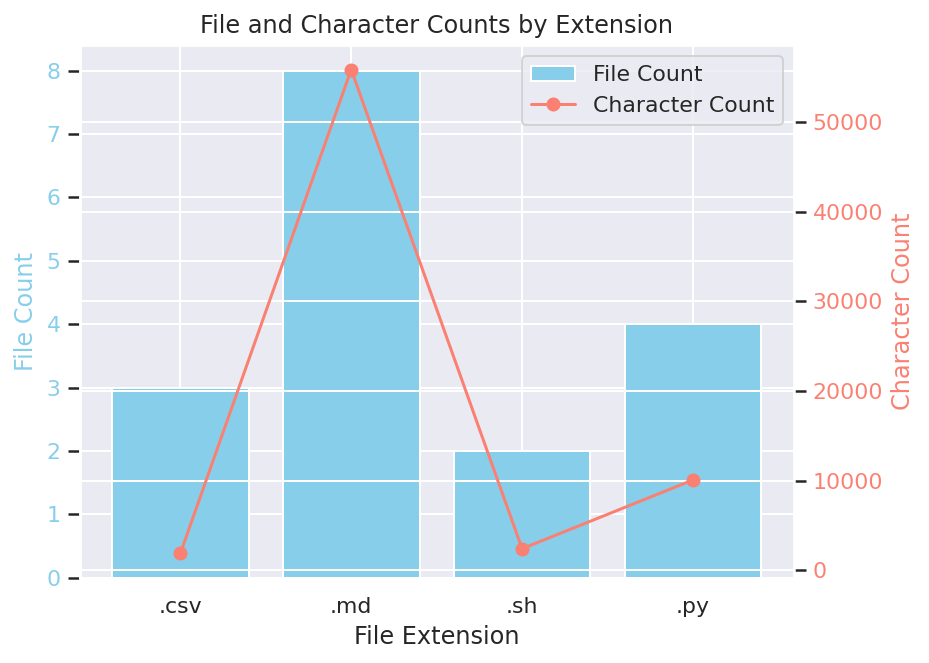

In [11]:
fig, ax1 = plt.subplots()

# Plotting File Count as bars
ax1.bar(df_counts['Extension'], df_counts['File Count'], color='skyblue', label='File Count')
ax1.set_xlabel('File Extension')
ax1.set_ylabel('File Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Creating a second y-axis for Character Count
ax2 = ax1.twinx()
ax2.plot(df_counts['Extension'], df_counts['Character Count'], color='salmon', marker='o', label='Character Count')
ax2.set_ylabel('Character Count', color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

# Adding title and legends
plt.title('File and Character Counts by Extension')
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

# Training

In [12]:
# --- Global Charset Calculation ---
# Collect all characters from the entire dataset
all_chars = "".join([content for content in dataset if content is not None])
charset = sorted(list(set(all_chars)))
charset_size = len(charset)
char_to_idx = {char: idx for idx, char in enumerate(charset)}
# -----------------------------------

charset_size

151

In [13]:
def custom_collate_fn(batch, char_to_idx, charset_size, context_size=5):
    """
    Optimized custom collate function to handle variable-length text data for a bag-of-words approach.
    For each character in the text, the input is a vector mean of its surrounding context
    (excluding the character itself), and the target is the character's index.

    Args:
        batch (list): A list of text content strings from the dataset.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
        context_size (int): The number of characters to consider on each side of the target character.

    Returns:
        tuple: A tuple containing batched inputs and targets.
    """
    all_batched_inputs = []
    all_batched_targets = []

    # Process each content string in the batch
    for content in batch:
        if content is None:
            continue

        # Convert the entire content string to a list of numerical indices.
        # Characters not found in `char_to_idx` are mapped to -1, which will be ignored later.
        content_indices = [char_to_idx.get(char, -1) for char in content]

        inputs_for_content = []
        targets_for_content = []

        # Iterate through each character and its corresponding index in the content
        for i, target_idx in enumerate(content_indices):
            # Only process if the current target character is known (its index is not -1)
            if target_idx == -1:
                continue

            # --- Targets ---
            # For each valid character, we generate two (input, target) pairs:
            # 1. (Target Char One-Hot, Target Char Index) -> "Token --> Token"
            # 2. (Context Mean One-Hot, Target Char Index) -> "Context --> Token"

            # --- Input for "Token --> Token" ---
            # Create a one-hot vector for the target character itself.
            token_vector = torch.zeros(charset_size, dtype=torch.float)
            token_vector[target_idx] = 1
            inputs_for_content.append(token_vector)
            targets_for_content.append(torch.tensor(target_idx, dtype=torch.long))

            # --- Input for "Context --> Token" ---
            # This involves averaging one-hot vectors of characters in the surrounding context.

            # Define the boundaries of the context window.
            # `start_idx_context` ensures we don't go before the beginning of the string.
            # `end_idx_context` ensures we don't go beyond the end of the string.
            start_idx_context = max(0, i - context_size)
            end_idx_context = min(len(content_indices), i + context_size + 1)

            context_chars_indices = []
            for k in range(start_idx_context, end_idx_context):
                # The target character itself should not be part of its own context.
                if k == i:
                    continue
                char_in_context_idx = content_indices[k]
                # Only include known characters (not -1) in the context sum.
                if char_in_context_idx != -1:
                    context_chars_indices.append(char_in_context_idx)

            # If there are valid characters in the context, compute their mean one-hot vector.
            if context_chars_indices:
                # Convert the list of context character indices into a PyTorch tensor.
                context_indices_tensor = torch.tensor(context_chars_indices, dtype=torch.long)
                # Generate one-hot vectors for all context characters simultaneously,
                # then average them up along the first dimension to get the bag-of-words context vector.
                context_vector = torch.mean(
                    torch.nn.functional.one_hot(context_indices_tensor, num_classes=charset_size).float(),
                    dim=0
                ).float()

                inputs_for_content.append(context_vector)
                targets_for_content.append(torch.tensor(target_idx, dtype=torch.long))
            else:
                # If no valid context characters, the context vector remains all zeros.
                # Ignore this case
                pass

        # After processing all characters in the current content string, add its generated
        # inputs and targets to the overall batch lists.
        if inputs_for_content:
            all_batched_inputs.extend(inputs_for_content)
            all_batched_targets.extend(targets_for_content)

    # After processing all content strings in the batch, stack all collected inputs and targets
    # into single PyTorch tensors.
    if all_batched_inputs:
        return torch.stack(all_batched_inputs), torch.stack(all_batched_targets)
    else:
        # If no valid data was found across the entire batch, return empty tensors
        # with appropriate shapes and data types to prevent errors in downstream processing.
        return torch.empty(0, charset_size, dtype=torch.float), torch.empty(0, dtype=torch.long)

In [14]:
def train_model(model, dataset, num_epochs, learning_rate, char_to_idx, charset_size, batch_size=32, context_size=5):
    """
    Helper function to train the CHV model using DataLoader and collate_fn,
    and record loss for each batch and epoch.

    Args:
        model (CHV): The CHV model to train.
        dataset (FileDataset): The dataset to train on.
        num_epochs (int): The number of training epochs.
        learning_rate (float): The learning rate for the optimizer.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
        batch_size (int): The batch size for the DataLoader.
        context_size (int): The number of characters to consider on each side of the target character.

    Returns:
        tuple: A tuple containing lists of batch losses and epoch losses.
    """
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: custom_collate_fn(batch, char_to_idx, charset_size, context_size))

    batch_losses = []
    epoch_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs_batch, targets_batch in dataloader:
            if inputs_batch.numel() == 0: # Skip empty batches
                continue

            optimizer.zero_grad()
            outputs = model(inputs_batch)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            total_loss += loss.item()
            num_batches += 1

            print(f"\rEpoch [{epoch+1}/{num_epochs}:{num_batches}:{inputs_batch.shape}], Loss: {loss.item():.4f}", end='')

        epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        epoch_losses.append(epoch_loss)
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}, Min Loss: {min(batch_losses[-num_batches:]):.4f}, Max Loss: {max(batch_losses[-num_batches:]):.4f}")

    return batch_losses, epoch_losses

In [15]:
vector_size = 6
model = CHV(charset_size, vector_size)

In [16]:
print(model)

CHV(
  (encoder): Linear(in_features=151, out_features=6, bias=True)
  (activation): Tanh()
  (expansion): Linear(in_features=6, out_features=53, bias=True)
  (nonlinear): Tanh()
  (decoder): Linear(in_features=53, out_features=151, bias=True)
)


In [17]:
batch_losses_0, epoch_losses_0 = train_model(model, dataset, num_epochs=40, learning_rate=0.06, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=0)

Epoch [1/40:6:torch.Size([9779, 151])], Loss: 7.0551
Epoch [1/40] Average Loss: 4.4644, Min Loss: 3.4346, Max Loss: 7.0551
Epoch [2/40:6:torch.Size([1103, 151])], Loss: 2.2497
Epoch [2/40] Average Loss: 2.4589, Min Loss: 1.4782, Max Loss: 3.4987
Epoch [3/40:6:torch.Size([402, 151])], Loss: 0.9552
Epoch [3/40] Average Loss: 1.1796, Min Loss: 0.5414, Max Loss: 3.1111
Epoch [4/40:6:torch.Size([1778, 151])], Loss: 0.5646
Epoch [4/40] Average Loss: 0.7860, Min Loss: 0.2070, Max Loss: 2.7382
Epoch [5/40:6:torch.Size([4883, 151])], Loss: 0.0922
Epoch [5/40] Average Loss: 0.3643, Min Loss: 0.0921, Max Loss: 1.5374
Epoch [6/40:6:torch.Size([26335, 151])], Loss: 0.0507
Epoch [6/40] Average Loss: 0.2520, Min Loss: 0.0507, Max Loss: 1.0703
Epoch [7/40:6:torch.Size([1618, 151])], Loss: 0.1917
Epoch [7/40] Average Loss: 0.1747, Min Loss: 0.0414, Max Loss: 0.6435
Epoch [8/40:6:torch.Size([3817, 151])], Loss: 0.0185
Epoch [8/40] Average Loss: 0.0847, Min Loss: 0.0185, Max Loss: 0.2932
Epoch [9/40:6:to

In [18]:
batch_losses_1_1, epoch_losses_1_1 = train_model(model, dataset, num_epochs=20, learning_rate=0.0006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=1)

Epoch [1/20:6:torch.Size([25712, 151])], Loss: 7.9566
Epoch [1/20] Average Loss: 8.3069, Min Loss: 7.2423, Max Loss: 9.1595
Epoch [2/20:6:torch.Size([53976, 151])], Loss: 9.0160
Epoch [2/20] Average Loss: 8.4032, Min Loss: 7.4238, Max Loss: 9.0430
Epoch [3/20:6:torch.Size([2452, 151])], Loss: 6.9268
Epoch [3/20] Average Loss: 8.2241, Min Loss: 6.9268, Max Loss: 9.0857
Epoch [4/20:6:torch.Size([4062, 151])], Loss: 7.0686
Epoch [4/20] Average Loss: 8.0343, Min Loss: 7.0686, Max Loss: 9.0168
Epoch [5/20:6:torch.Size([2756, 151])], Loss: 8.1748
Epoch [5/20] Average Loss: 8.2303, Min Loss: 7.6132, Max Loss: 8.9182
Epoch [6/20:6:torch.Size([3742, 151])], Loss: 7.5819
Epoch [6/20] Average Loss: 8.0220, Min Loss: 7.3754, Max Loss: 8.8313
Epoch [7/20:6:torch.Size([12616, 151])], Loss: 8.3792
Epoch [7/20] Average Loss: 7.8485, Min Loss: 7.1222, Max Loss: 8.7810
Epoch [8/20:6:torch.Size([8868, 151])], Loss: 8.2530
Epoch [8/20] Average Loss: 7.7733, Min Loss: 6.8898, Max Loss: 8.6610
Epoch [9/20:6

In [19]:
batch_losses_1_2, epoch_losses_1_2 = train_model(model, dataset, num_epochs=10, learning_rate=0.006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=1)

Epoch [1/10:6:torch.Size([51756, 151])], Loss: 7.0159
Epoch [1/10] Average Loss: 6.7772, Min Loss: 6.1237, Max Loss: 7.4116
Epoch [2/10:6:torch.Size([6398, 151])], Loss: 5.4142
Epoch [2/10] Average Loss: 6.3071, Min Loss: 5.0948, Max Loss: 7.2943
Epoch [3/10:6:torch.Size([15134, 151])], Loss: 4.5832
Epoch [3/10] Average Loss: 5.5590, Min Loss: 4.5832, Max Loss: 6.0223
Epoch [4/10:6:torch.Size([17022, 151])], Loss: 4.5970
Epoch [4/10] Average Loss: 4.9297, Min Loss: 4.3264, Max Loss: 5.3458
Epoch [5/10:6:torch.Size([9854, 151])], Loss: 4.1594
Epoch [5/10] Average Loss: 4.5559, Min Loss: 3.7884, Max Loss: 5.6445
Epoch [6/10:6:torch.Size([16412, 151])], Loss: 5.2069
Epoch [6/10] Average Loss: 4.1912, Min Loss: 3.6301, Max Loss: 5.2069
Epoch [7/10:6:torch.Size([18436, 151])], Loss: 4.6471
Epoch [7/10] Average Loss: 3.7214, Min Loss: 3.3128, Max Loss: 4.6471
Epoch [8/10:6:torch.Size([2764, 151])], Loss: 3.1868
Epoch [8/10] Average Loss: 3.3289, Min Loss: 3.0835, Max Loss: 3.9723
Epoch [9/10

In [20]:
batch_losses_3, epoch_losses_3 = train_model(model, dataset, num_epochs=20, learning_rate=0.006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=3)

Epoch [1/20:6:torch.Size([24454, 151])], Loss: 2.2121
Epoch [1/20] Average Loss: 2.5640, Min Loss: 2.1961, Max Loss: 3.4782
Epoch [2/20:6:torch.Size([19558, 151])], Loss: 2.9594
Epoch [2/20] Average Loss: 2.3081, Min Loss: 2.0659, Max Loss: 2.9594
Epoch [3/20:6:torch.Size([8868, 151])], Loss: 2.1104
Epoch [3/20] Average Loss: 2.2696, Min Loss: 2.0409, Max Loss: 3.0920
Epoch [4/20:6:torch.Size([18436, 151])], Loss: 2.7824
Epoch [4/20] Average Loss: 2.1764, Min Loss: 1.8918, Max Loss: 2.7824
Epoch [5/20:6:torch.Size([16412, 151])], Loss: 2.7937
Epoch [5/20] Average Loss: 2.1926, Min Loss: 1.9121, Max Loss: 2.7937
Epoch [6/20:6:torch.Size([2568, 151])], Loss: 1.9848
Epoch [6/20] Average Loss: 2.0903, Min Loss: 1.8684, Max Loss: 2.6185
Epoch [7/20:6:torch.Size([28010, 151])], Loss: 1.8166
Epoch [7/20] Average Loss: 2.0802, Min Loss: 1.8166, Max Loss: 2.6477
Epoch [8/20:6:torch.Size([29288, 151])], Loss: 2.2469
Epoch [8/20] Average Loss: 1.9939, Min Loss: 1.7679, Max Loss: 2.2469
Epoch [9/2

In [21]:
batch_losses_6, epoch_losses_6 = train_model(model, dataset, num_epochs=10, learning_rate=0.0006, char_to_idx=char_to_idx, charset_size=charset_size, batch_size=3, context_size=6)

Epoch [1/10:6:torch.Size([53470, 151])], Loss: 1.7351
Epoch [1/10] Average Loss: 1.7593, Min Loss: 1.6087, Max Loss: 1.9823
Epoch [2/10:6:torch.Size([13564, 151])], Loss: 1.6791
Epoch [2/10] Average Loss: 1.7871, Min Loss: 1.6696, Max Loss: 1.9724
Epoch [3/10:6:torch.Size([688, 151])], Loss: 2.1066
Epoch [3/10] Average Loss: 1.7888, Min Loss: 1.6216, Max Loss: 2.1066
Epoch [4/10:6:torch.Size([3556, 151])], Loss: 1.9489
Epoch [4/10] Average Loss: 1.7941, Min Loss: 1.5987, Max Loss: 2.0421
Epoch [5/10:6:torch.Size([3482, 151])], Loss: 1.7962
Epoch [5/10] Average Loss: 1.7114, Min Loss: 1.5422, Max Loss: 1.7962
Epoch [6/10:6:torch.Size([9594, 151])], Loss: 1.7027
Epoch [6/10] Average Loss: 1.7484, Min Loss: 1.6023, Max Loss: 2.1054
Epoch [7/10:6:torch.Size([16412, 151])], Loss: 2.0977
Epoch [7/10] Average Loss: 1.7712, Min Loss: 1.6681, Max Loss: 2.0977
Epoch [8/10:6:torch.Size([16172, 151])], Loss: 1.5286
Epoch [8/10] Average Loss: 1.7379, Min Loss: 1.5286, Max Loss: 1.9911
Epoch [9/10:6

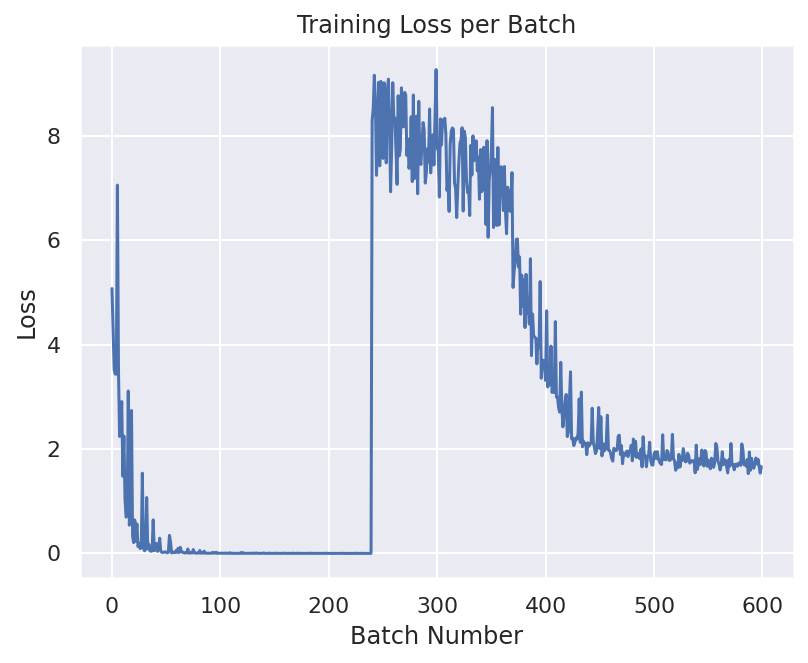

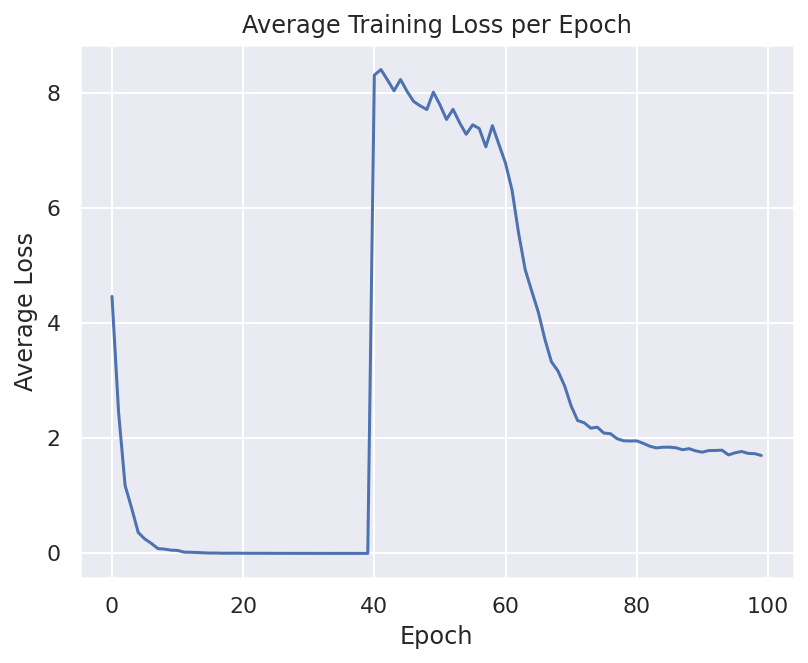

In [22]:
# Plotting batch losses
plt.figure()
plt.plot(batch_losses_0 + batch_losses_1_1 + batch_losses_1_2 + batch_losses_3 + batch_losses_6, label='Batch Loss')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.show()

# Plotting epoch losses
plt.figure()
plt.plot(epoch_losses_0 + epoch_losses_1_1 + epoch_losses_1_2 + epoch_losses_3 + epoch_losses_6, label='Epoch Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Training Loss per Epoch')
plt.show()

# Model Testing

In [23]:
def test_model(model, sentence, char_to_idx, charset_size):
    """
    Tests the CHV model with a given sentence.

    Args:
        model (CHV): The trained CHV model.
        sentence (str): The input sentence for testing.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.
    """
    model.eval() # Set the model to evaluation mode

    print(f"Input Sentence: '{sentence}'")
    print("\nCharacter Embeddings:")

    embeddings = []
    reconstructed_outputs = []
    reconstructed_chars = []

    idx_to_char = {idx: char for char, idx in char_to_idx.items()} # Create index to character mapping

    with torch.no_grad(): # Disable gradient calculation for inference
        softmax = torch.nn.Softmax(dim=-1) # For probabilistic output

        for char in sentence:
            if char in char_to_idx:
                # Create one-hot encoding for the character
                one_hot = torch.zeros(charset_size)
                one_hot[char_to_idx[char]] = 1
                input_tensor = one_hot.unsqueeze(0) # Add batch dimension

                # Get the embedding
                embedding = model.encode(input_tensor).squeeze(0)
                embeddings.append(embedding.numpy()) # Store as NumPy array

                # Get the reconstructed output (probabilities)
                reconstructed = softmax(model.decode(embedding.unsqueeze(0)))
                reconstructed_outputs.append(reconstructed.numpy()) # Store as NumPy array

                # Get the index of the most likely character
                predicted_idx = torch.argmax(reconstructed).item()
                reconstructed_char = idx_to_char.get(predicted_idx, '?') # Get character, use '?' for unknown
                reconstructed_chars.append(reconstructed_char)

                print(f"  Character '{char}': {embedding.tolist()}")
            else:
                print(f"  Character '{char}': Not in charset")
                reconstructed_chars.append('?') # Add '?' for unknown characters in reconstructed string

    print("\nEncode-Decode Output vs Original:")
    for i, char in enumerate(sentence):
        if char in char_to_idx:
            original_one_hot = torch.zeros(charset_size)
            original_one_hot[char_to_idx[char]] = 1
            original_output = original_one_hot.numpy()
            reconstructed_output = reconstructed_outputs[i]

            print(f"  Character '{char}':")
            print(f"    Original (One-Hot): {original_output.tolist()}")
            print(f"    Reconstructed (Probabilities): {reconstructed_output.tolist()}")
            print(f"    Reconstructed Character: '{reconstructed_chars[i]}'")

        else:
             print(f"  Character '{char}': Not in charset - Cannot compare")
             print(f"    Reconstructed Character: '{reconstructed_chars[i]}'")


    print(f"\nReconstructed Sentence: {''.join(reconstructed_chars)}")

In [24]:
test_model(model, 'Hello World! in Character Vector by Avaktrahu Shashthishalaka', char_to_idx, charset_size)

Input Sentence: 'Hello World! in Character Vector by Avaktrahu Shashthishalaka'

Character Embeddings:
  Character 'H': [0.8110752701759338, -0.0942625030875206, 0.3966846168041229, -0.08726457506418228, -0.620047926902771, 0.8905881643295288]
  Character 'e': [-0.19086553156375885, 0.9348779916763306, 0.2505504786968231, -0.9844626188278198, 0.9240471720695496, -0.8085041046142578]
  Character 'l': [0.9605441689491272, -0.027028607204556465, -0.8219472169876099, -0.22048914432525635, 0.9898536205291748, 0.4017270505428314]
  Character 'l': [0.9605441689491272, -0.027028607204556465, -0.8219472169876099, -0.22048914432525635, 0.9898536205291748, 0.4017270505428314]
  Character 'o': [0.9703613519668579, 0.3721778988838196, 0.4042987525463104, 0.4352375566959381, 0.9868965744972229, -0.6917719841003418]
  Character ' ': [-0.3687942326068878, -0.21844486892223358, 0.5695818066596985, -0.9514216780662537, 0.8817322850227356, -0.0966595709323883]
  Character 'W': [0.2745439410209656, 0.2921

In [25]:
# Generate embeddings for all characters in the charset
all_char_embeddings = []
for char in charset:
    if char in char_to_idx:
        one_hot = torch.zeros(charset_size)
        one_hot[char_to_idx[char]] = 1
        input_tensor = one_hot.unsqueeze(0)
        embedding = model.encode(input_tensor).squeeze(0).detach().numpy() # Detach and convert to numpy
        all_char_embeddings.append(embedding)

# Convert embeddings to a pandas DataFrame for easier plotting
embeddings_df = pd.DataFrame(all_char_embeddings, index=charset)

embeddings_df.describe()

,0,1,2,3,4,5
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.010114,-0.065559,0.078470,0.022276,-0.049551,-0.010611
std,0.558160,0.508274,0.497677,0.601934,0.519835,0.520559
min,-0.910882,-0.932426,-0.856913,-0.993827,-0.909651,-0.905706
25%,-0.476435,-0.454034,-0.307941,-0.446827,-0.462184,-0.428706
50%,-0.008727,-0.140024,0.130046,0.138406,-0.123260,-0.046456
75%,0.490380,0.295917,0.487156,0.547485,0.272298,0.428555
max,0.984322,0.978787,0.951762,0.927333,0.990453,0.929811


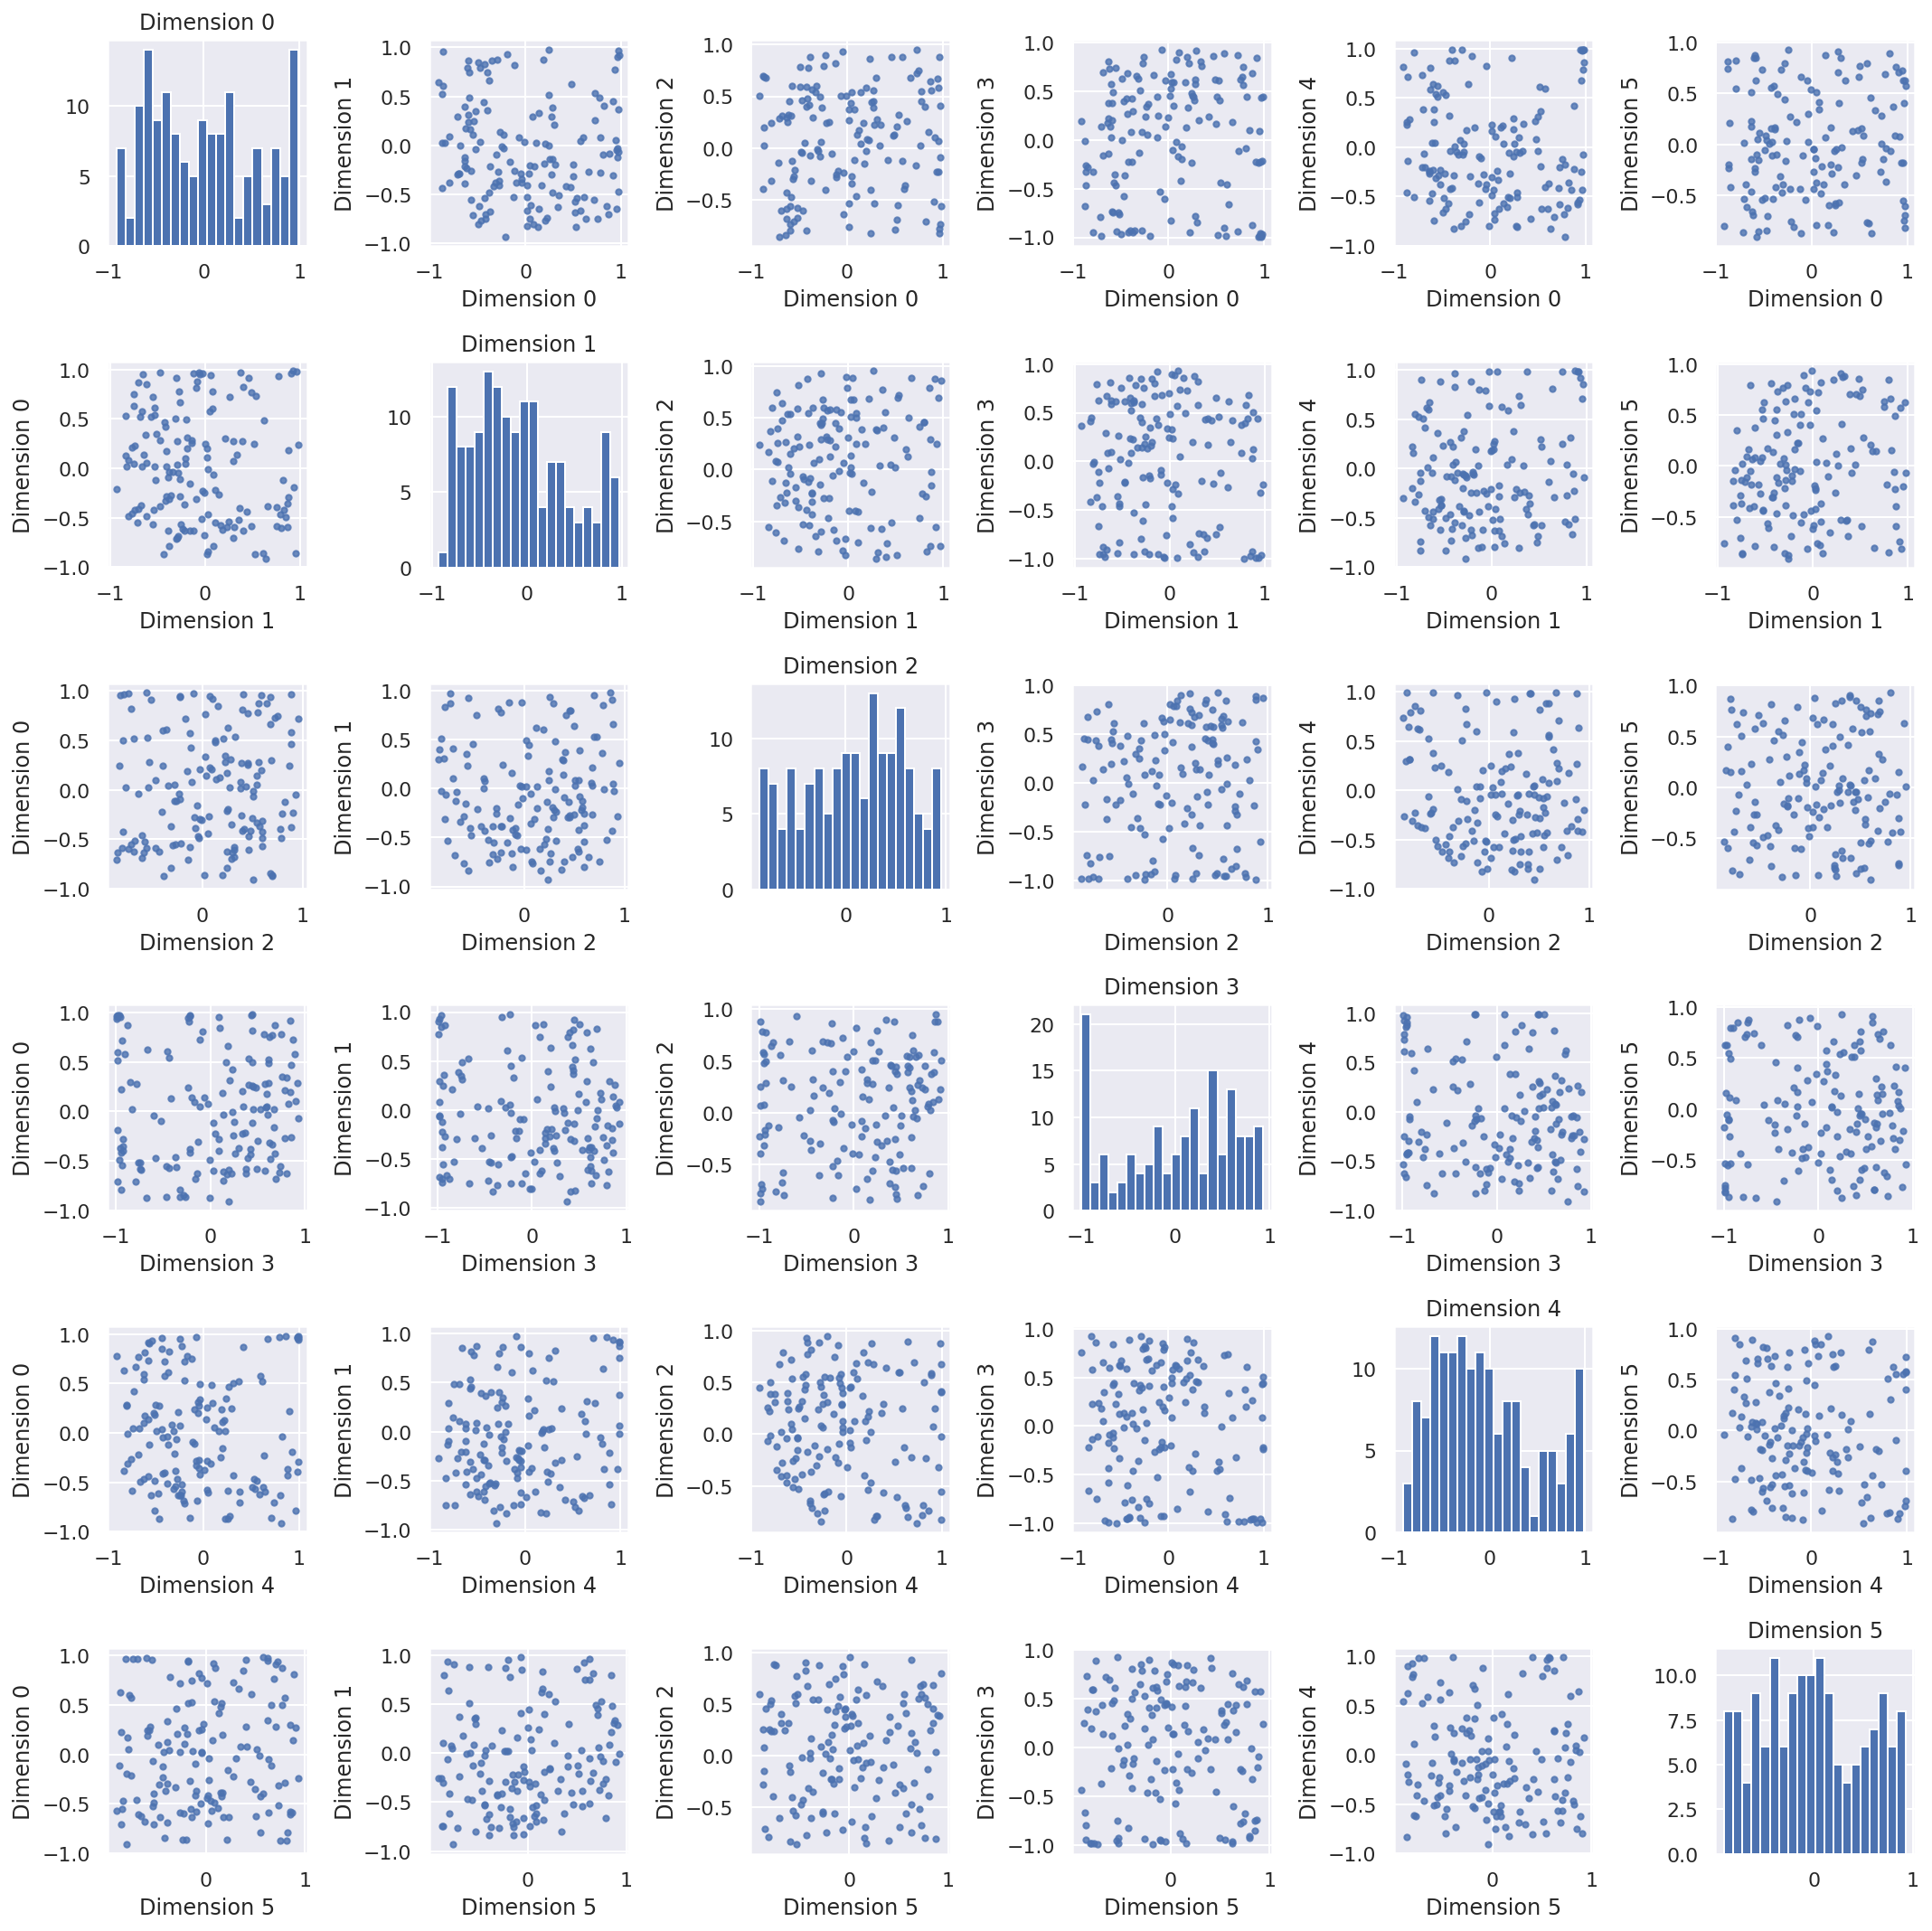

In [26]:
# Generate 2D scatter plots for all combinations of pairs of dimensions
num_dimensions = embeddings_df.shape[1]
fig, axes = plt.subplots(num_dimensions, num_dimensions, figsize=(15, 15))

for i in range(num_dimensions):
    for j in range(num_dimensions):
        if i == j:
            # Plot histogram on the diagonal
            embeddings_df[i].plot(kind='hist', bins=20, ax=axes[i, j])
            axes[i, j].set_title(f'Dimension {i}')
            axes[i, j].set_xlabel('')
            axes[i, j].set_ylabel('')
        else:
            # Plot scatter plot for off-diagonal
            embeddings_df.plot(kind='scatter', x=i, y=j, s=10, alpha=.8, ax=axes[i, j])
            axes[i, j].set_xlabel(f'Dimension {i}')
            axes[i, j].set_ylabel(f'Dimension {j}')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3202 (\N{KANNADA SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Kannada natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3205 (\N{KANNADA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3206 (\N{KANNADA LETTER AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3207 (\N{KANNADA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-

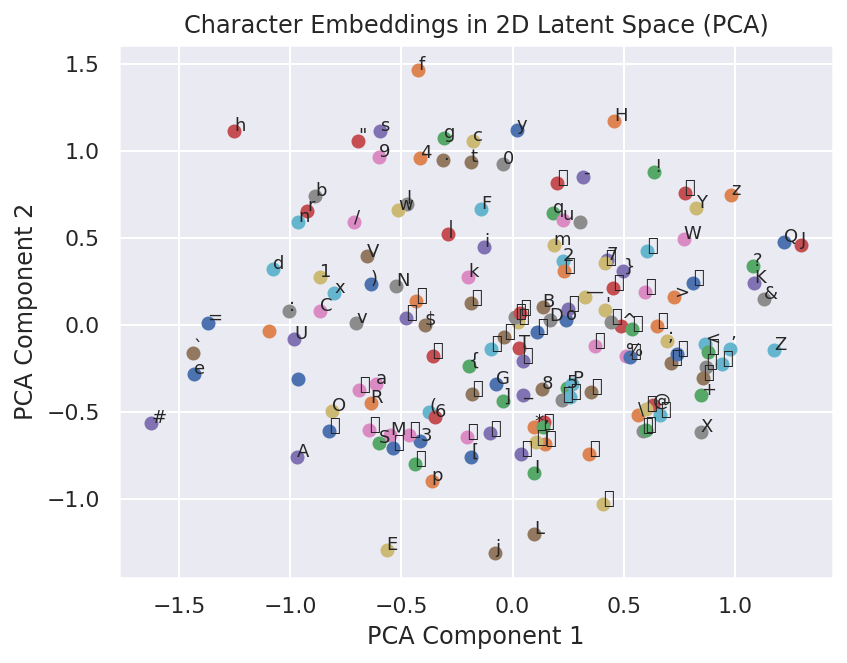

In [27]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(all_char_embeddings)

# Create a 2D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Plot each character
for i, char in enumerate(charset):
    ax.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o')
    ax.text(embeddings_2d[i, 0], embeddings_2d[i, 1], char, fontsize=9)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
plt.title('Character Embeddings in 2D Latent Space (PCA)')

plt.show()

In [28]:
def evaluate_charset_reconstruction(model, charset, char_to_idx, charset_size):
    """
    Evaluates how well the model reconstructs each character in the charset using batch processing.

    Args:
        model (CHV): The trained CHV model.
        charset (list): The list of all characters in the charset.
        char_to_idx (dict): A dictionary mapping characters to their indices.
        charset_size (int): The total size of the character set.

    Returns:
        tuple: A tuple containing lists of original indices and predicted indices.
    """
    model.eval()  # Set the model to evaluation mode
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    softmax = torch.nn.Softmax(dim=-1)

    print("Evaluating Charset Reconstruction (Batched):")
    misreconstructed_chars = []
    original_indices = []
    predicted_indices = []

    with torch.no_grad():
        # Create a batch of one-hot encoded characters for the entire charset
        input_batch = torch.zeros(len(charset), charset_size)
        chars_in_batch = []


        for i, char in enumerate(charset):
            if char in char_to_idx:
                input_batch[i, char_to_idx[char]] = 1
                chars_in_batch.append(char)


        if input_batch.numel() == 0:
            print("No valid characters in the charset to evaluate.")
            return [], []

        # Get the embeddings and reconstructed outputs for the entire batch
        embeddings = model.encode(input_batch)
        reconstructed_outputs = softmax(model.decode(embeddings))

        # Get the predicted indices for the batch
        predicted_indices_batch = torch.argmax(reconstructed_outputs, dim=1).tolist()

        # Collect original and predicted indices and identify misreconstructed characters
        for i, original_char in enumerate(chars_in_batch):
             original_idx = char_to_idx[original_char]
             predicted_idx = predicted_indices_batch[i]
             original_indices.append(original_idx)
             predicted_indices.append(predicted_idx)

             reconstructed_char = idx_to_char.get(predicted_idx, '?')
             if original_char != reconstructed_char:
                 misreconstructed_chars.append(f"'{original_char}' (encoded to '{reconstructed_char}')")


    if misreconstructed_chars:
        print("\nCharacters not reconstructed properly:")
        for char_pair in misreconstructed_chars:
            print(char_pair)
    else:
        print("\nAll characters in the charset were reconstructed properly.")

    return original_indices, predicted_indices

original_indices, predicted_indices = evaluate_charset_reconstruction(model, charset, char_to_idx, charset_size)

Evaluating Charset Reconstruction (Batched):

Characters not reconstructed properly:
'^' (encoded to '*')
'ಘ' (encoded to 'ೇ')
'ಠ' (encoded to 'ೇ')
'—' (encoded to 'ು')
'🐳' (encoded to 'o')


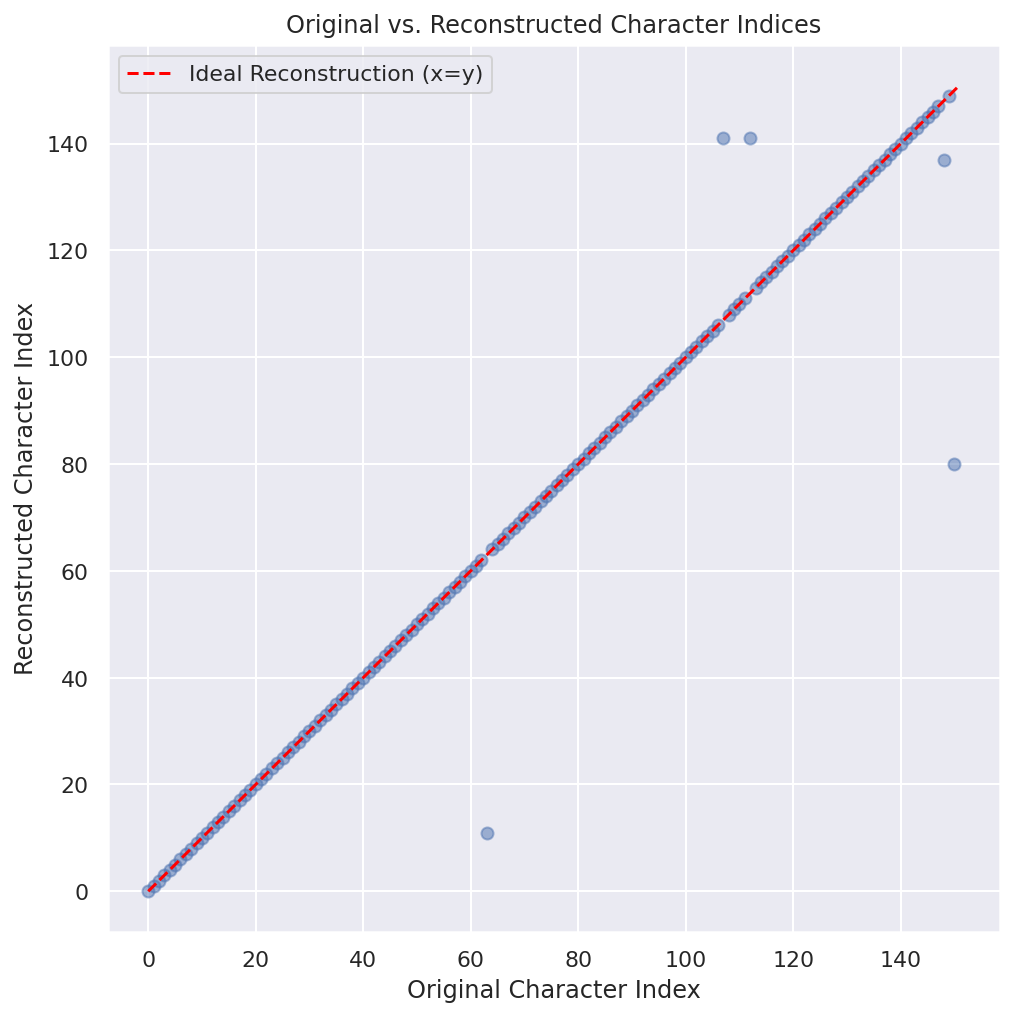

In [29]:
plt.figure(figsize=(8, 8))
plt.scatter(original_indices, predicted_indices, alpha=0.5)
plt.plot([0, charset_size], [0, charset_size], color='red', linestyle='--', label='Ideal Reconstruction (x=y)')
plt.xlabel('Original Character Index')
plt.ylabel('Reconstructed Character Index')
plt.title('Original vs. Reconstructed Character Indices')
plt.legend()
plt.grid(True)
plt.show()